In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
csv_path = os.path.join('..', 'data', 'data_set_final_processed.csv')

In [3]:
df = pd.read_csv(csv_path, low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100511 entries, 0 to 100510
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   LOJA                       100511 non-null  object 
 1   DATA_VENDA                 100511 non-null  object 
 2   LOJA_ID                    100511 non-null  object 
 3   CIDADE                     100511 non-null  object 
 4   REGIAO                     100511 non-null  object 
 5   PRODUTIVIDADE_HORA         100511 non-null  float64
 6   TOTAL_COLABORADORES        100511 non-null  float64
 7   SKUS                       100511 non-null  float64
 8   CAIXAS_TRADICIONAIS        100511 non-null  float64
 9   SELF_CHECKOUT              100511 non-null  float64
 10  ABERTURA_LOJA              100511 non-null  object 
 11  FECHO_LOJA                 100511 non-null  object 
 12  ITEMS                      100511 non-null  float64
 13  VALOR_VENDA                10

In [5]:
# Keep the original dataframe separate
original_df = df.copy()

In [6]:
# Convert 'DATA_VENDA' to datetime and handle missing values
df['DATA_VENDA'] = pd.to_datetime(df['DATA_VENDA'], errors='coerce')
df['TIPO_FERIADO'] = df['TIPO_FERIADO'].fillna('None')

In [7]:
# Sort the DataFrame
df.sort_values(['LOJA', 'DATA_VENDA'], inplace=True)

In [8]:
# Create lag features and rolling means
df['lag_7'] = df.groupby('LOJA')['VALOR_VENDA'].shift(7)
df['rolling_mean_15'] = df.groupby('LOJA')['VALOR_VENDA'].shift(1).rolling(15).mean()

# Fill missing values in lag and rolling mean features
df.fillna({'lag_7': 0}, inplace=True)
df.fillna({'rolling_mean_15': df['rolling_mean_15'].mean()}, inplace=True)

In [9]:
# Drop unnecessary columns
columns_to_drop = ['DATA_VENDA','ABERTURA_LOJA', 'FECHO_LOJA', 'DATA_FERIADO', 'ITEMS', 'rolling_avg_items', 'TEMPO_ABERTURA', 'LOJA']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [10]:
# Check for null values
null_counts = df.isnull().sum()
print("Null values in each column:")
print(null_counts)

Null values in each column:
LOJA_ID                           0
CIDADE                            0
REGIAO                            0
PRODUTIVIDADE_HORA                0
TOTAL_COLABORADORES               0
SKUS                              0
CAIXAS_TRADICIONAIS               0
SELF_CHECKOUT                     0
VALOR_VENDA                       0
SKUS_UP                           0
SKUS_DOWN                         0
AUMENTO_PRECO                     0
DESCIDA_PRECO                     0
TIPO_FERIADO                      0
FERIADO_FIXO                  99078
ABERTURA_FERIADO              99078
NOME_EVENTO                  100477
INICIO_EVENTO                100477
FIM_EVENTO                   100477
HORAS_ABERTURA                    0
day_of_week                       0
rolling_avg_sales               246
rolling_avg_SKUS_UP             248
rolling_avg_SKUS_DOWN           248
rolling_avg_AUMENTO_PRECO       248
rolling_avg_DESCIDA_PRECO       248
lag_7                             0


In [11]:
# Handle missing values in the rest of the dataset

# Drop columns with a high number of null values (threshold: 50% null values)
df = df.dropna(thresh=len(df) * 0.5, axis=1)

# Fill null values with median for numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Fill any remaining null values in categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].ffill()

In [12]:
# Define features and target variable
X = df.drop(columns=['VALOR_VENDA'])
y = df['VALOR_VENDA']

In [13]:
# Fill null values with median for numeric columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

# Fill any remaining null values in categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
X[categorical_columns] = X[categorical_columns].ffill()

In [14]:
# Ensure that 'lag_7' and 'rolling_mean_15' are included in the features
print("Features in X:")
print(X.columns)

Features in X:
Index(['LOJA_ID', 'CIDADE', 'REGIAO', 'PRODUTIVIDADE_HORA',
       'TOTAL_COLABORADORES', 'SKUS', 'CAIXAS_TRADICIONAIS', 'SELF_CHECKOUT',
       'SKUS_UP', 'SKUS_DOWN', 'AUMENTO_PRECO', 'DESCIDA_PRECO',
       'TIPO_FERIADO', 'HORAS_ABERTURA', 'day_of_week', 'rolling_avg_sales',
       'rolling_avg_SKUS_UP', 'rolling_avg_SKUS_DOWN',
       'rolling_avg_AUMENTO_PRECO', 'rolling_avg_DESCIDA_PRECO', 'lag_7',
       'rolling_mean_15'],
      dtype='object')


In [15]:
# Ensure there are no remaining NaN values
X = X.fillna(0)

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print("Training Features:")
print(X_train)
print("Test Features:")
print(X_test)
print("Training Target:")
print(y_train)
print("Test Target:")
print(y_test)

Training Features:
      LOJA_ID             CIDADE          REGIAO  PRODUTIVIDADE_HORA  \
62725  POR432  Costa da Caparica      Margem Sul               212.0   
22296  POR008  Vila Nova de Gaia           Porto               210.0   
29091  POR026               Maia           Porto               229.0   
95822  POR036          Vila Real    Região Norte               234.0   
59194  POR414             Lisboa  Lisboa Central               162.0   
...       ...                ...             ...                 ...   
6265   POR052   Caldas da Rainha    Lisboa Norte               136.0   
54886   U0142             Lisboa  Lisboa Central                 0.0   
76820  POR417             Almada      Margem Sul               225.0   
860    POR025          Alfragide  Lisboa Central               269.0   
15795  POR062              Eiras   Beira Litoral               172.0   

       TOTAL_COLABORADORES     SKUS  CAIXAS_TRADICIONAIS  SELF_CHECKOUT  \
62725                 15.0   2929.0      

In [18]:
# Define preprocessing for numerical and categorical data
numeric_features = numeric_columns
categorical_features = categorical_columns

In [19]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create and train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [20]:
X_train

,LOJA_ID,CIDADE,REGIAO,PRODUTIVIDADE_HORA,TOTAL_COLABORADORES,SKUS,CAIXAS_TRADICIONAIS,SELF_CHECKOUT,SKUS_UP,SKUS_DOWN,...,TIPO_FERIADO,HORAS_ABERTURA,day_of_week,rolling_avg_sales,rolling_avg_SKUS_UP,rolling_avg_SKUS_DOWN,rolling_avg_AUMENTO_PRECO,rolling_avg_DESCIDA_PRECO,lag_7,rolling_mean_15
62725,POR432,Costa da Caparica,Margem Sul,212.0,15.0,2929.0,16.0,0.0,5405.0,5405.0,...,Dia do Trabalhador,12.0,6,8183.5950,427.50,464.75,16.0525,14.1000,8904.85,8933.619333
22296,POR008,Vila Nova de Gaia,Porto,210.0,56.0,37764.0,14.0,5.0,32196.0,32196.0,...,None,14.0,3,83088.8400,5956.00,5567.50,14.8150,13.7550,84773.27,86616.550000
29091,POR026,Maia,Porto,229.0,58.0,40519.0,14.0,3.0,43761.0,43761.0,...,None,15.0,4,134808.6425,5878.50,5952.75,13.8000,14.8300,148507.09,108524.290000
95822,POR036,Vila Real,Região Norte,234.0,19.0,8465.0,7.0,3.0,17952.0,17952.0,...,None,13.0,4,56816.3250,1186.75,1198.75,14.9775,15.5750,54028.05,52349.832000
59194,POR414,Lisboa,Lisboa Central,162.0,13.0,3224.0,17.0,0.0,3081.0,3081.0,...,None,12.0,0,5070.8925,467.75,495.25,15.3800,14.1800,5075.14,5214.556667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,POR052,Caldas da Rainha,Lisboa Norte,136.0,7.0,2760.0,4.0,4.0,4911.0,4911.0,...,None,13.0,1,9907.4975,159.50,953.50,5.0650,39.1900,9145.67,11053.039333
54886,U0142,Lisboa,Lisboa Central,0.0,13.0,3172.0,15.0,0.0,2047.0,2047.0,...,None,12.0,4,4685.8800,510.50,482.50,16.3600,15.2475,4772.17,4566.746667
76820,POR417,Almada,Margem Sul,225.0,16.0,3059.0,17.0,0.0,3421.0,3421.0,...,None,12.0,4,6693.6600,462.25,515.50,15.0650,17.0750,6492.18,6281.247333
860,POR025,Alfragide,Lisboa Central,269.0,85.0,35052.0,26.0,8.0,49489.0,49489.0,...,None,13.0,2,155368.1050,4779.75,4854.00,12.4075,13.5700,150883.10,192105.894000


In [21]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['PRODUTIVIDADE_HORA', 'TOTAL_COLABORADORES', 'SKUS',
       'CAIXAS_TRADICIONAIS', 'SELF_CHECKOUT', 'SKUS_UP', 'SKUS_DOWN',
       'AUMENTO_PRECO', 'DESCIDA_PRECO', 'HORAS_ABERTURA', 'day_of_week',
       'rolling_avg_sales', 'rolling_avg_SKUS_UP', 'rolling_avg_SKUS_DOWN',
       'rolling_avg_AUMENTO_PRECO', 'rolling_avg_DESCIDA_PRECO', 'lag_7',
       'rolling_mean_15'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['LOJA_ID', 'CIDADE', 'REGIAO', 'TIPO_FERIADO'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [22]:
# Predict on test set
y_pred = model.predict(X_test)

In [23]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 64192869.695598334
Mean Absolute Error: 3864.866680608301
R-squared: 0.9828194200846485


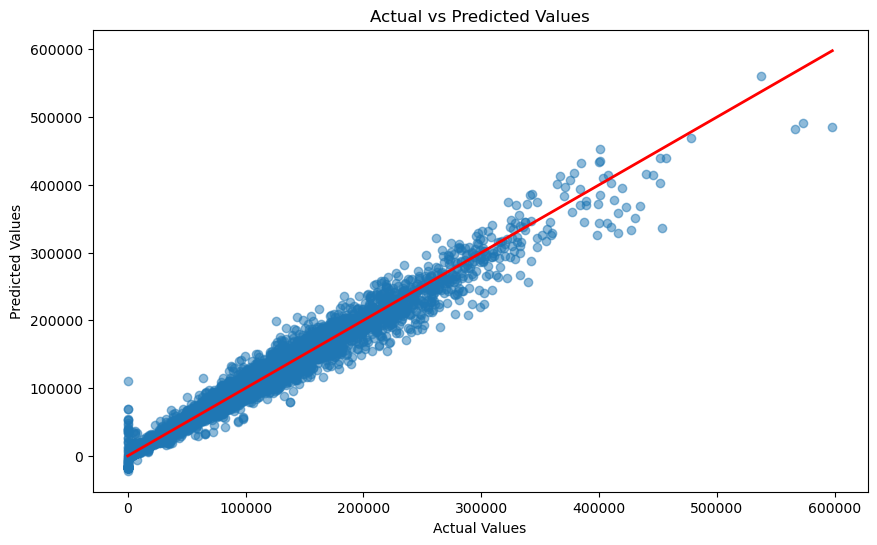

In [24]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Line of equality
plt.show()

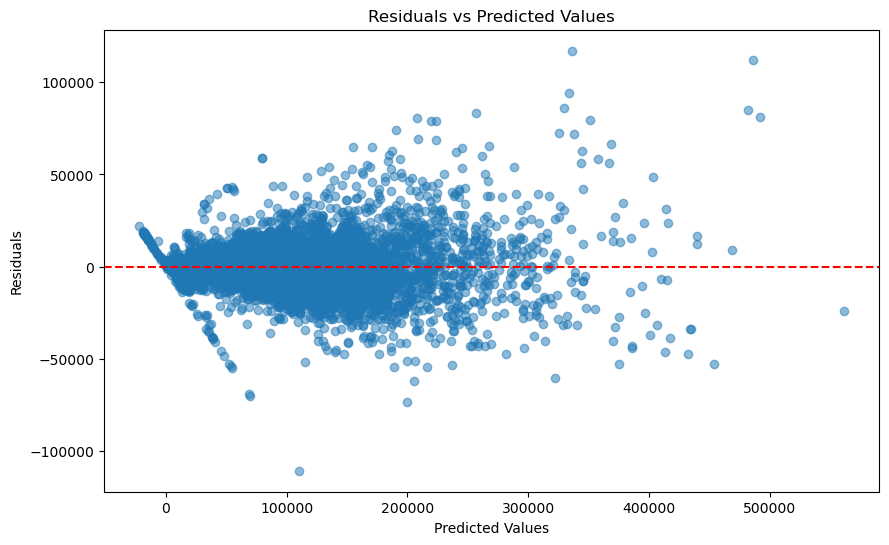

In [25]:
# Residual plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

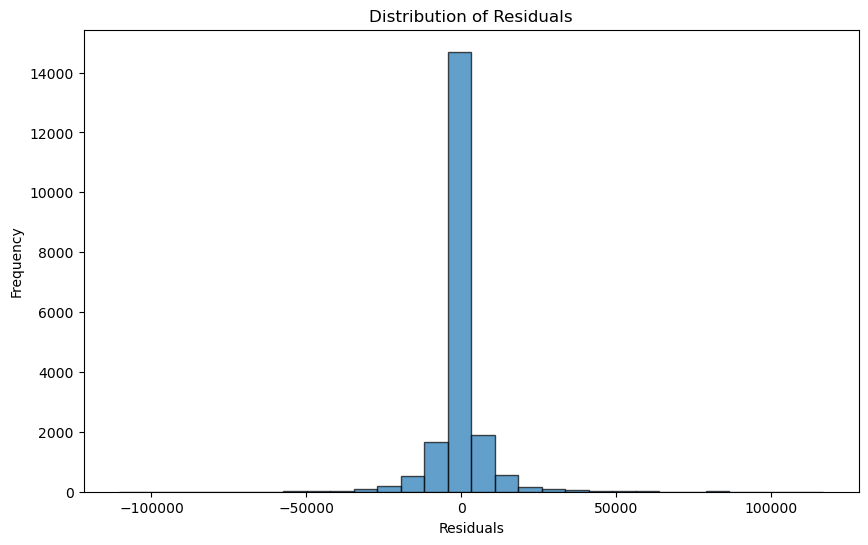

In [26]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

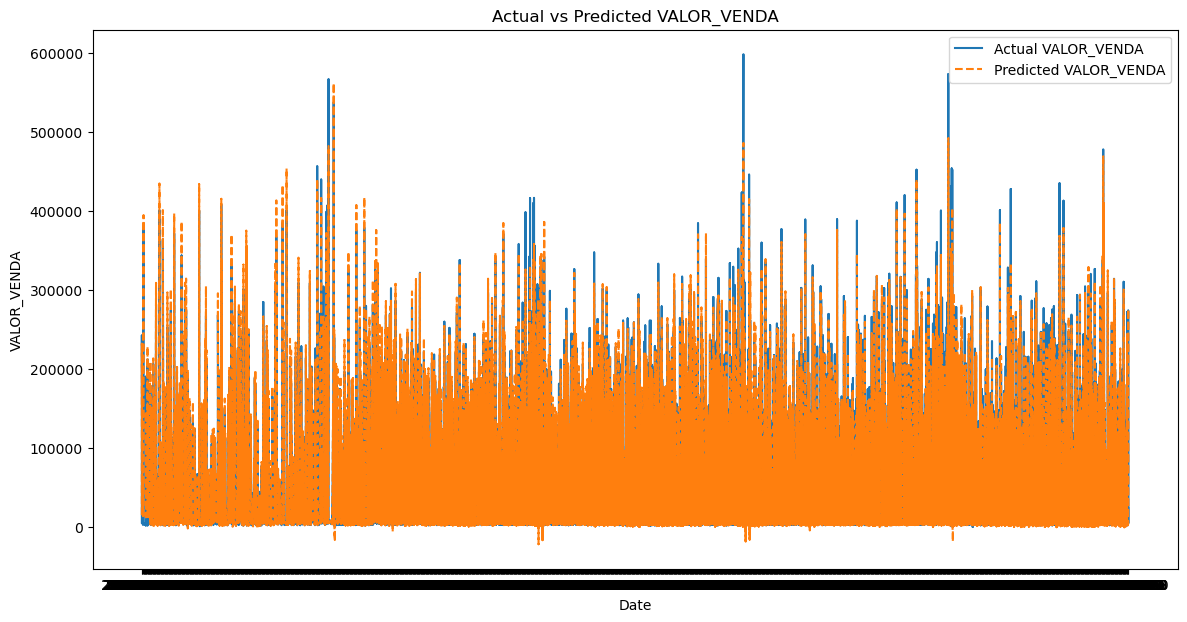

In [27]:
# Create a DataFrame for y_test and y_pred to easily handle the dates
results_df = pd.DataFrame({
    'DATA_VENDA': original_df.loc[y_test.index, 'DATA_VENDA'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort by date to ensure proper plotting
results_df.sort_values('DATA_VENDA', inplace=True)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(results_df['DATA_VENDA'], results_df['Actual'], label='Actual VALOR_VENDA')
plt.plot(results_df['DATA_VENDA'], results_df['Predicted'], label='Predicted VALOR_VENDA', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VALOR_VENDA')
plt.title('Actual vs Predicted VALOR_VENDA')
plt.legend()
plt.show()

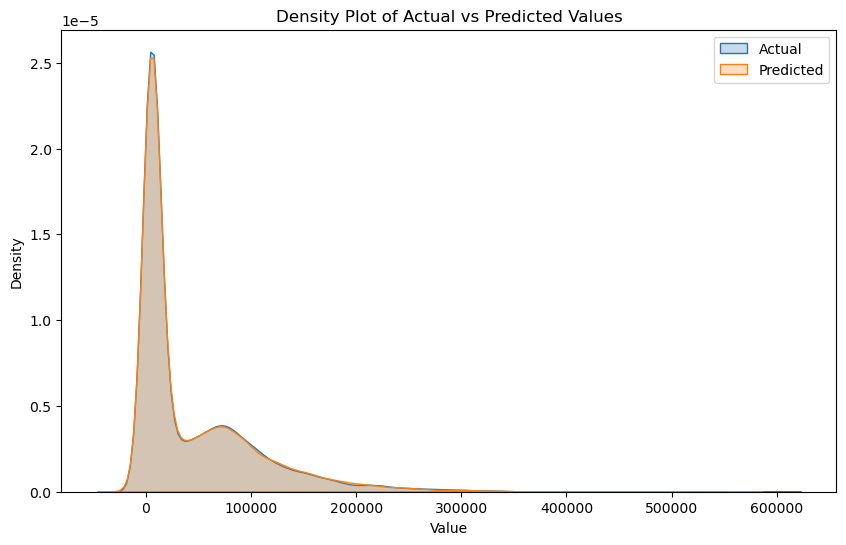

In [28]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Actual vs Predicted Values')
plt.legend()
plt.show()